Programming for Data Analytics POE from Hakim Messi ST1002700

The goal of this analysis is to create a model that predicts medical aid costs based on the patient attributes (features). 

In [84]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

After importing librabries, which i will add a few a long the way I instanly start to explore my dataset to better understand it so I can be build a good model. 

In [85]:
# load the dataset, can be found in the same dir. 
df = pd.read_csv('insurance.csv')

# the first few rows of the dataset
print(df.head())
# the few row at the end of the dataset
print(df.tail())


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
      age     sex    bmi  children smoker     region     charges
1333   50    male  30.97         3     no  northwest  10600.5483
1334   18  female  31.92         0     no  northeast   2205.9808
1335   18  female  36.85         0     no  southeast   1629.8335
1336   21  female  25.80         0     no  southwest   2007.9450
1337   61  female  29.07         0    yes  northwest  29141.3603


Let's find out the numbers of entries, data types and columns in the dataset etc. The following line of codes will provides a better insight in the state of our dataset. 

In [86]:
# the shape of the dataset, this will show the number of rows and columns
print(df.shape)

(1338, 7)


In [87]:
#the columns of the dataset, this will show the names of the columns
print(df.columns)
# the data types of the columns, this will show the data types of the columns
print(df.dtypes)


Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [88]:
# the info of the dataset, this will show the number of non-null values in each column and the data type of each column
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [89]:
# indentify the categorical columns, this will show the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

Categorical columns: Index(['sex', 'smoker', 'region'], dtype='object')


In [90]:
# the number of missing values in each column, this will show the number of missing values in each column
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [91]:
# the number of unique values in each column, this will show the number of unique values in each column
print(df.nunique())

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


In [92]:
# comprehensive encoding for all categorical variables/colums
# first i copy the DataFrame to avoid modifying the original
df_processed = df.copy()

# for 'sex' (binary)
# using label encoding
df_processed['sex_encoded'] = LabelEncoder().fit_transform(df_processed['sex'])

# for 'smoker' (binary)
# using label encoding 
df_processed['smoker_encoded'] = LabelEncoder().fit_transform(df_processed['smoker'])

# for 'region' (nominal with multiple categories)
# using one-hot encoding
region_dummies = pd.get_dummies(df_processed['region'], prefix='region', drop_first=True)
df_processed = pd.concat([df_processed, region_dummies], axis=1)

# now dropping the original categorical columns, cause i hate confusion
df_processed = df_processed.drop(['sex', 'smoker', 'region'], axis=1)

# see the result
print(df_processed.head())

   age     bmi  children      charges  sex_encoded  smoker_encoded  \
0   19  27.900         0  16884.92400            0               1   
1   18  33.770         1   1725.55230            1               0   
2   28  33.000         3   4449.46200            1               0   
3   33  22.705         0  21984.47061            1               0   
4   32  28.880         0   3866.85520            1               0   

   region_northwest  region_southeast  region_southwest  
0             False             False              True  
1             False              True             False  
2             False              True             False  
3              True             False             False  
4              True             False             False  



In [93]:
# the statistical summary of the dataset, this will show the mean, standard deviation, minimum, maximum, and quartiles of each column
print(df_processed.describe())


               age          bmi     children       charges  sex_encoded  \
count  1338.000000  1338.000000  1338.000000   1338.000000  1338.000000   
mean     39.207025    30.663397     1.094918  13270.422265     0.505232   
std      14.049960     6.098187     1.205493  12110.011237     0.500160   
min      18.000000    15.960000     0.000000   1121.873900     0.000000   
25%      27.000000    26.296250     0.000000   4740.287150     0.000000   
50%      39.000000    30.400000     1.000000   9382.033000     1.000000   
75%      51.000000    34.693750     2.000000  16639.912515     1.000000   
max      64.000000    53.130000     5.000000  63770.428010     1.000000   

       smoker_encoded  
count     1338.000000  
mean         0.204783  
std          0.403694  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000  


Lets check if there is any linear relationship, we evaluate the dataset for suitability to apply a Linear Regression algorithm.

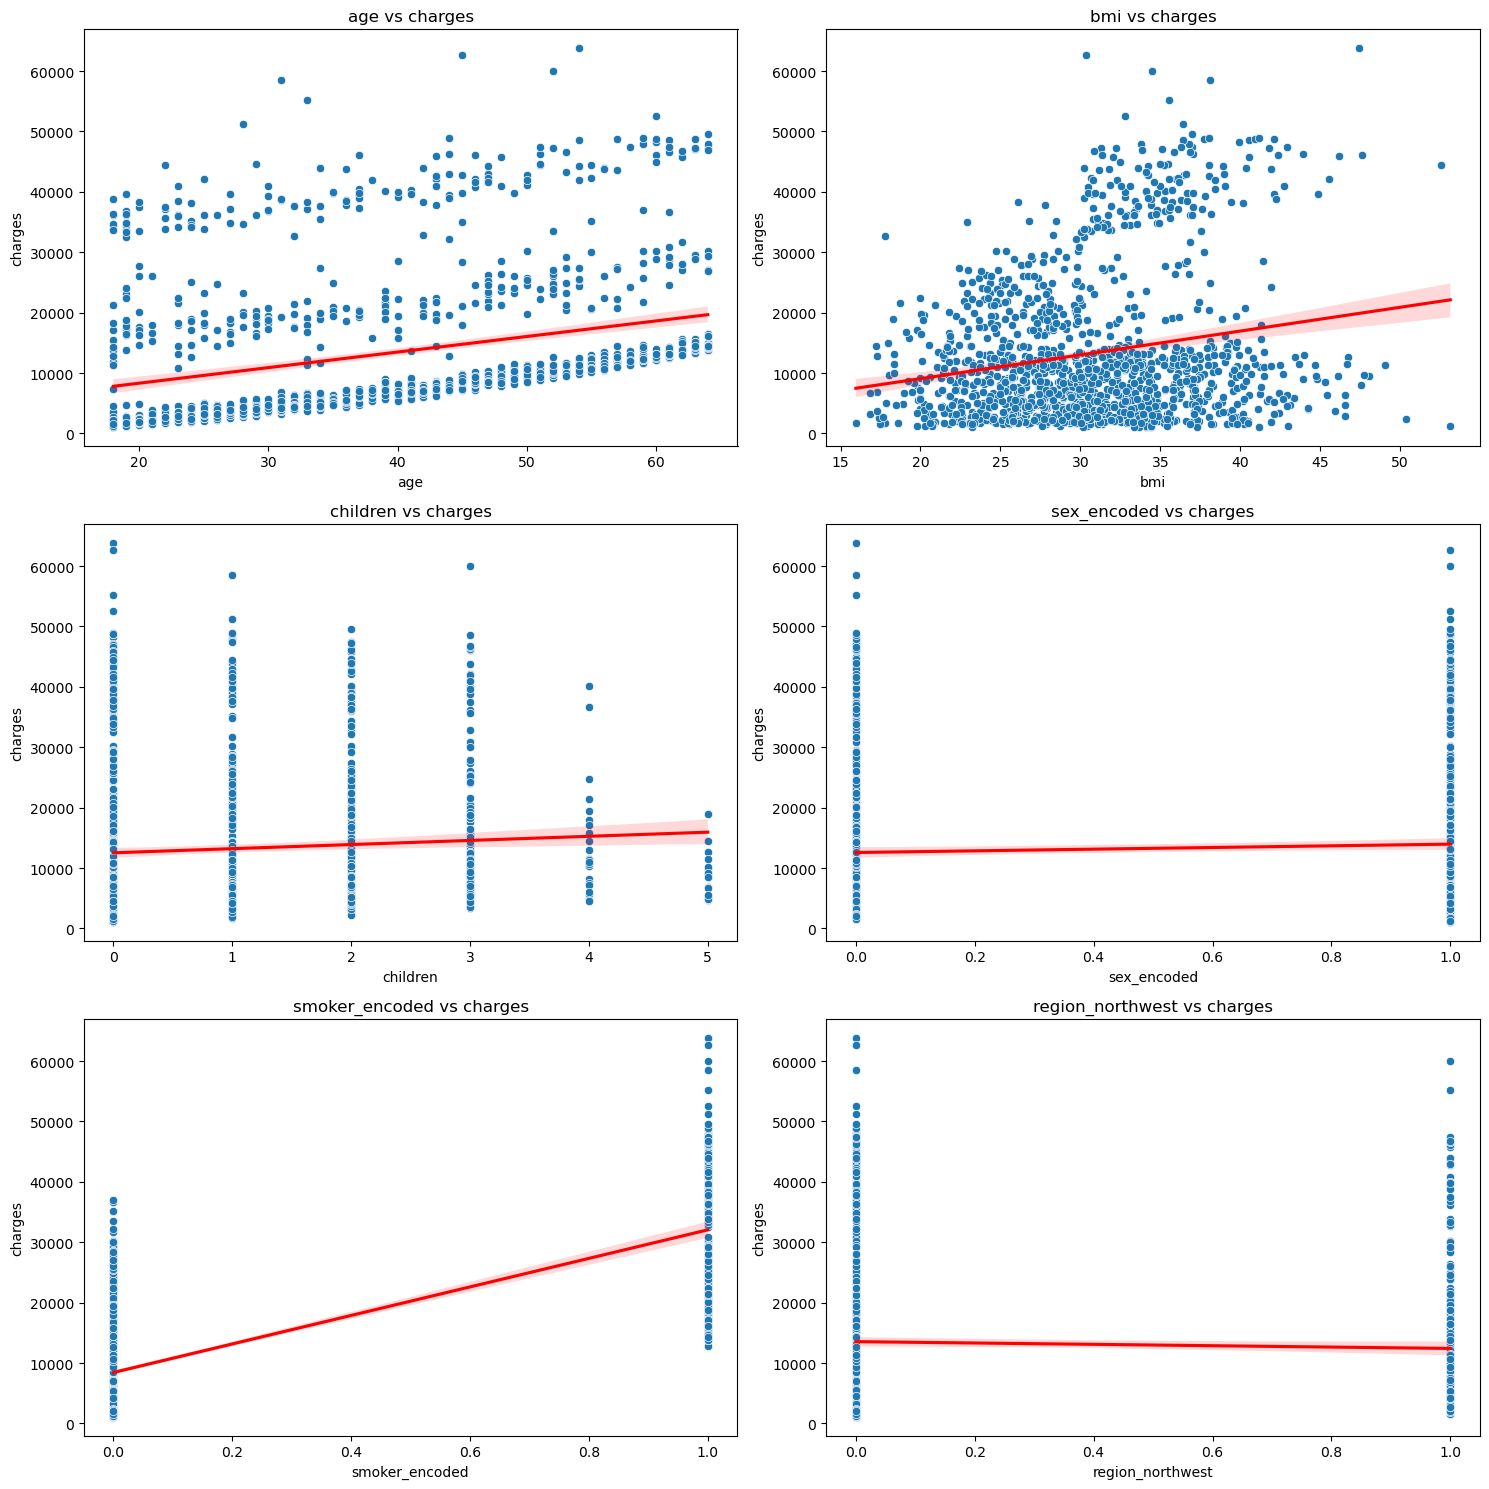

In [94]:
# set up numerical features for analysis
numerical_features = ['age', 'bmi', 'children', 'sex_encoded', 'smoker_encoded']
target = 'charges'

# adding the one-hot encoded region columns to numerical features
# this will add the one-hot encoded region columns to the numerical features
region_columns = [col for col in df_processed.columns if col.startswith('region_')]
numerical_features.extend(region_columns)


# create a grid of subplots with 3 rows and 2 columns
# this will be used to visualize multiple plots in a single figure
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# flatten the axes array to make it easier to iterate through
# this allows us to access each subplot individually
axes = axes.flatten()

# iterate through the first 6 numerical features for visualization
for i, feature in enumerate(numerical_features[:6]):  # Limit to first 6 features for visibility
    # create a scatter plot for each feature against the target variable
    sns.scatterplot(x=feature, y=target, data=df_processed, ax=axes[i])
    # set the title of the subplot
    axes[i].set_title(f'{feature} vs {target}')
    
    # add a regression line to the scatter plot
    sns.regplot(x=feature, y=target, data=df_processed, scatter=False, ax=axes[i], color='red')

# adjust the layout to prevent overlapping and display the plots
plt.tight_layout()
plt.show()

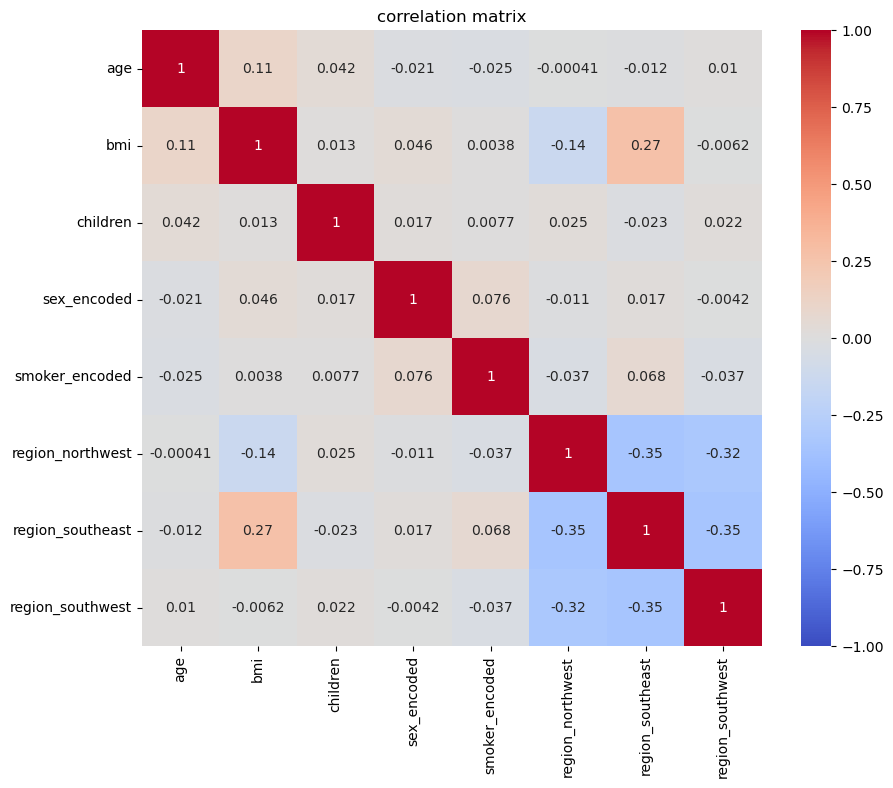

In [95]:
# calculate the correlation matrix for numerical features
correlation_matrix = df_processed[numerical_features].corr()

# plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('correlation matrix')
plt.show()


In [ ]:
# calculate the VIF for each feature
X = df_processed[numerical_features].copy()  # create a DataFrame to store features for VIF calculation

# explicitly convert all columns to float64 type
X = X.astype(float)

# ensure all data is numeric and handle any potential issues
X = X.apply(pd.to_numeric, errors='coerce')  # Convert any non-numeric values to NaN
X = X.fillna(X.mean())  # Fill NaN values with mean

# check for and handle any infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# print data types to verify all columns are numeric
print("Data types before VIF calculation:")
print(X.dtypes)

# add a constant to the DataFrame for the intercept
X = sm.add_constant(X)  # Add constant term for regression

# debug sample: print X info before VIF calculation
print("X shape:", X.shape)
print("X contains NaN:", X.isna().any().any())
print("X first few rows:")
print(X.head())

# calculate Variation Inflation Factor for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values.astype(float), i) for i in range(X.shape[1])]

# filter out the constant term from the VIF results for clarity
vif_data = vif_data[vif_data["Feature"] != "const"]

print(vif_data)  # VIF > 5-10 indicates problematic multicollinearity

Data types before VIF calculation:
age                 float64
bmi                 float64
children            float64
sex_encoded         float64
smoker_encoded      float64
region_northwest    float64
region_southeast    float64
region_southwest    float64
dtype: object
X shape: (1338, 9)
X contains NaN: False
X first few rows:
   const   age     bmi  children  sex_encoded  smoker_encoded  \
0    1.0  19.0  27.900       0.0          0.0             1.0   
1    1.0  18.0  33.770       1.0          1.0             0.0   
2    1.0  28.0  33.000       3.0          1.0             0.0   
3    1.0  33.0  22.705       0.0          1.0             0.0   
4    1.0  32.0  28.880       0.0          1.0             0.0   

   region_northwest  region_southeast  region_southwest  
0               0.0               0.0               1.0  
1               0.0               1.0               0.0  
2               0.0               1.0               0.0  
3               1.0               0.0        